### Imports

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from time import time
import os
import wandb
from wandb.keras import WandbCallback
import numpy as np

### Logging code

In [17]:
TENSORBOARD_LOGS_DIR = f"dandc-{int(time())}"
tensorboard = TensorBoard(log_dir=f"logs/{TENSORBOARD_LOGS_DIR}", write_images=True, histogram_freq=1, write_grads=True)
# run = wandb.init()
# config = run.config
config = {}




### Network Configuration

In [18]:
config['img_width'] = 150
config['img_height'] = 150
config['first_layer_conv_width'] = 3
config['first_layer_conv_height'] = 3
config['dense_layer_size'] = 512
config['epochs'] = 10
config['optimizer'] = "adam"
config['hidden_nodes'] = 100

### Images Dataset

In [19]:
base_dir = 'E:\kaggle\dogs-and-cats\sm_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


### Data Generation

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Inspect Generators

In [21]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


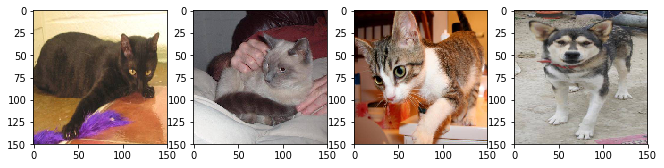

In [27]:
%matplotlib inline
rcParams['figure.figsize'] = 11, 8

fig, ax = plt.subplots(1,4)
for data_batch, labels_batch in train_generator:
    ax[0].imshow(data_batch[0])
    ax[1].imshow(data_batch[1])
    ax[2].imshow(data_batch[2])
    ax[3].imshow(data_batch[3])
    break

### Normalization

In [6]:
X_train = X_train.astype("float32")
X_train /= 255.

NameError: name 'X_train' is not defined

In [7]:
X_test = X_test.astype("float32")
X_test /= 255.

NameError: name 'X_test' is not defined

### Reshape input data

In [8]:
X_train = X_train.reshape(X_train.shape[0], config.img_width, config.img_height, 1)
X_test = X_test.reshape(X_test.shape[0], config.img_width, config.img_height, 1)

NameError: name 'X_train' is not defined

### One hot encoder outputs

In [9]:
ohe_y_train = np_utils.to_categorical(y_train)
ohe_y_train[0]

NameError: name 'y_train' is not defined

In [10]:
ohe_y_test = np_utils.to_categorical(y_test)

NameError: name 'y_test' is not defined

In [11]:
labels = range(10)
num_classes = ohe_y_train.shape[1]
num_classes

NameError: name 'ohe_y_train' is not defined

### Create Model

In [15]:
model = Sequential()
model.add(Conv2D(32,
                (config.first_layer_conv_width, config.first_layer_conv_height),
                input_shape=(config.img_width, config.img_height, 1),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(config.dense_layer_size, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Training

In [53]:
model.fit(X_train, ohe_y_train, epochs=config.epochs, validation_data=(X_test, ohe_y_test), callbacks=[tensorboard])

Resuming run: https://app.wandb.ai/martin-fabbri-a/dl-playground-cnn_vanilla-cnn/runs/7fnucdif
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 38s 626us/step - loss: 0.2465 - acc: 0.9257 - val_loss: 0.0724 - val_acc: 0.9769
Epoch 2/10
60000/60000 [==============================] - 39s 642us/step - loss: 0.1123 - acc: 0.9663 - val_loss: 0.0558 - val_acc: 0.9827
Epoch 3/10
60000/60000 [==============================] - 39s 649us/step - loss: 0.0893 - acc: 0.9727 - val_loss: 0.0482 - val_acc: 0.9835
Epoch 4/10
60000/60000 [==============================] - 42s 701us/step - loss: 0.0758 - acc: 0.9761 - val_loss: 0.0432 - val_acc: 0.9861
Epoch 5/10
60000/60000 [==============================] - 51s 848us/step - loss: 0.0654 - acc: 0.9796 - val_loss: 0.0405 - val_acc: 0.9870
Epoch 6/10
60000/60000 [==============================] - 42s 695us/step - loss: 0.0587 - acc: 0.9819 - val_loss: 0.0395 - val_acc: 0.9872
Epoch 7/10
60000/6000

In [50]:
print(model.predict(X_test[:10, :, :]))

[[1.73543675e-13 3.65288633e-10 4.33253043e-12 1.62437130e-11
  1.84767717e-16 5.33469662e-16 9.87337707e-20 1.00000000e+00
  1.72748765e-13 1.90798870e-11]
 [3.34723174e-15 8.40872438e-09 1.00000000e+00 6.50517840e-19
  4.80413666e-22 1.90171606e-24 5.57408242e-16 2.58628979e-18
  1.88477156e-18 4.14596944e-18]
 [8.23017710e-10 9.99999762e-01 1.86846667e-11 2.59408901e-15
  1.04410638e-07 4.61910837e-13 1.05423146e-12 1.59096714e-07
  1.43521584e-10 1.48042342e-11]
 [1.00000000e+00 3.56308263e-15 2.40348408e-10 5.22343562e-13
  2.49431192e-15 4.57779919e-13 9.07102216e-09 5.22247935e-13
  3.92273436e-11 5.53180522e-11]
 [8.80977402e-10 4.17813223e-12 8.86749216e-11 1.65801368e-12
  9.99995947e-01 2.82711940e-12 4.63566199e-11 1.86316761e-11
  5.16626706e-08 3.99362489e-06]
 [5.64312208e-11 9.99995351e-01 7.28048698e-12 1.24176453e-14
  8.96265018e-09 1.89103206e-14 4.86668431e-13 4.70710074e-06
  4.53579702e-10 3.49431040e-11]
 [2.51405943e-16 1.95646416e-10 5.26441390e-12 6.77085428e

In [68]:
print(is_five_train[:50])

[ True False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False  True
 False False]
